In [79]:
## Import packages

import h5py
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


In [80]:
## Definitions

def gauss(x, H, A, x0, sigma):                 # define a Gaussian function for easily
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):                           # define fitting function 
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [81]:
## Load file and read (meta-) data

Title = 'Data2'                                # set a descriptive title for data set

data = h5py.File('data2.hdf5','r')             # load file

sensor = np.array(data['data/sensor'])         # read sensor and mapping data as numpy array
mapping = np.array(data['data/mapping'])

indN0 = np.nonzero(mapping)                    # find non-zero elements in mapping array
sensor = sensor[indN0]                         # extract sensor data for mapping != zero only
mapping = mapping[indN0]

dset = data['data']                            # dataset = group object
Attributes_names = list(dset.attrs.keys())     # read atrribute names
Attributes_values = list(dset.attrs.values())  # read attribute values

N_height = Attributes_values[Attributes_names.index("image_height")]                # read number of pixels for height and width of image
N_width = Attributes_values[Attributes_names.index("image_width")]

N_data = len(sensor)
N_pixels = int(N_height*N_width)


In [82]:
## Create image

intensity = np.arange(N_pixels)                # init summed intensity values as 1D array with zeros

# NOTE: This code works for all data sets, also with varying number of samples per pixel, even for mapping like '1122112' with only one sample per pixel
c, = np.where(mapping==2)                      # find indices of mapping data = 2
idx2 = np.concatenate([np.array([-1,-1]),c])   # effectivlely puts a '-1' first to also sum first pixel correctly
idx2 = np.delete(idx2, 0)

for i_pix in range(N_pixels):                  # sums up sensor values between mapping values of '2'
    intensity[i_pix] = sum(sensor[idx2[i_pix]+1 : idx2[i_pix+1]+1])
    
image = np.reshape(intensity,(-1,N_width))      # reshape 1D intensity array to 2D image matrix


# NOTE: If the number of samples per pixel is constant like in the first data file, you also can do it like this:
# (However, the first way is more general and to prefer!)

#image = np.array([[0 for x in range(N_width)] for y in range(N_height)] )  # init as matrix with zeros
#N_sample = int(N_data/N_pixels)                # number of samples for one pixel
#for i_row in range(N_height):
#    for i_col in range(N_width):
#        image[i_row][i_col] = sum(sensor[N_sample*(i_col+i_row*N_width) : N_sample*(i_col+i_row*N_width+1)])


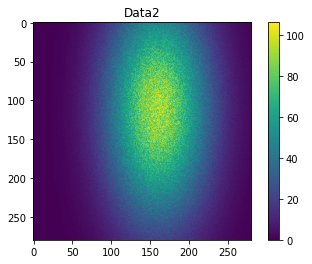

In [83]:
## Plot and save image

fig = plt.figure()
plt.title(Title)
plt.imshow(image) 
plt.colorbar(orientation='vertical')
plt.savefig(Title + '_image.png')
plt.close(fig)


281
Standard deviation sigma of the Gaussian is  46.31250980908061


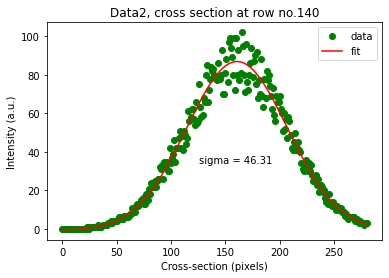

In [84]:
## Analyse and plot data, save results

# Define Line number for row of interest (ROI)

# Middle
N_ROI = int(N_height/2)
# or manual
#N_ROI = 140

y_ROI = np.array(image[N_ROI-1,:])
x_ROI = list(range(N_width))
print(len(x_ROI))

H, A, x0, sigma = gauss_fit(x_ROI, y_ROI)      # do the fitting
print('Standard deviation sigma of the Gaussian is ',sigma)

# Plot everything
plt.plot(x_ROI,y_ROI,'go', label='data',)
plt.plot(x_ROI, gauss(x_ROI, *gauss_fit(x_ROI, y_ROI)), '-r', label='fit')
plt.title(Title + ", cross section at row no." + str(N_ROI))
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Cross-section (pixels)')
plt.legend()
plt.text(0.45*max(x_ROI) ,max(y_ROI/3) ,"sigma = "+str(round(sigma,2)))
plt.savefig(Title + '_CrossSection_analysis.png')
plt.close(fig)


In [85]:
## Delete data before analysing next data set (opt.)

del image
del intensity
del mapping
del sensor